<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-07-24 13:19:58--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2020-07-24 13:19:58 (13.3 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

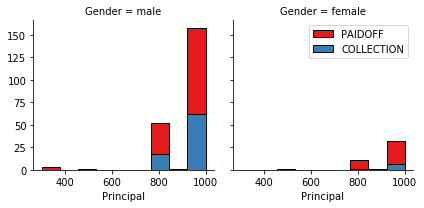

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

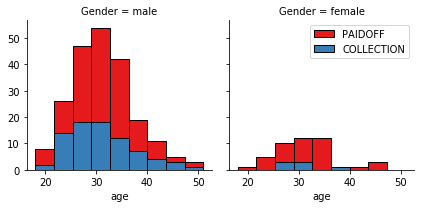

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

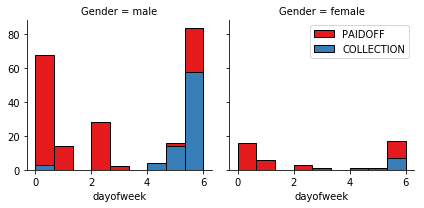

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


<h2>---- Other Pre-processing Actions: START ----</h2>

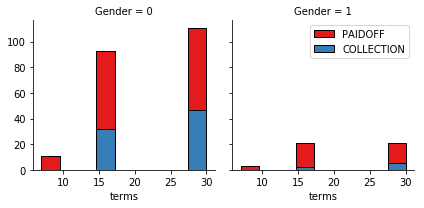

In [17]:
bins = np.linspace(df.terms.min(), df.terms.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'terms', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

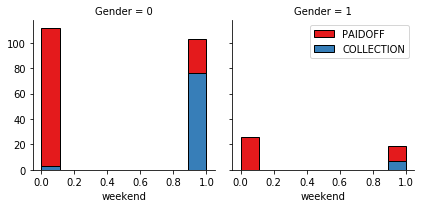

In [18]:
bins = np.linspace(df.weekend.min(), df.weekend.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'weekend', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

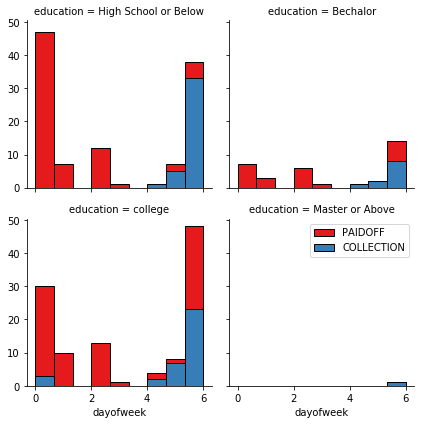

In [19]:
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="education", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

In [20]:
df[['age']].describe()
bins_age = np.array([18,25,35,45,52])
#bins_age = np.linspace(18, 52, 4)
group_ages = ['18-25', '25-35', '35-45', '45-52']
group_ages_df = pd.cut(df['age'], bins_age, labels=group_ages, include_lowest=True )
fch = pd.DataFrame(group_ages_df)
fch['gender'] = df['Gender']
fch['loan_status'] = df['loan_status']
fch.rename(columns={'age':'age_binned'}, inplace=True)
fch.head()
fch.groupby(['age_binned'])['loan_status'].value_counts(normalize=True)

age_binned  loan_status
18-25       PAIDOFF        0.714286
            COLLECTION     0.285714
25-35       PAIDOFF        0.761261
            COLLECTION     0.238739
35-45       PAIDOFF        0.754098
            COLLECTION     0.245902
45-52       PAIDOFF        0.714286
            COLLECTION     0.285714
Name: loan_status, dtype: float64

In [21]:
df.groupby(['terms'])['loan_status'].value_counts(normalize=True)

terms  loan_status
7      PAIDOFF        1.000000
15     PAIDOFF        0.770270
       COLLECTION     0.229730
30     PAIDOFF        0.717391
       COLLECTION     0.282609
Name: loan_status, dtype: float64

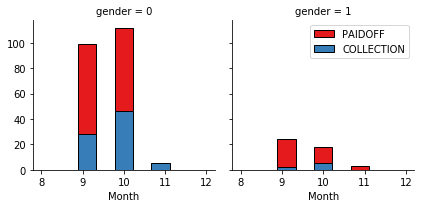

In [22]:
fch['Month'] = df.due_date.dt.month
bins = np.linspace(fch.Month.min()-1, fch.Month.max()+1, 10)
g = sns.FacetGrid(fch, col="gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Month', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

In [23]:
fch.groupby(['Month', 'gender'])['loan_status'].value_counts(normalize=True)

Month  gender  loan_status
9      0       PAIDOFF        0.779528
               COLLECTION     0.220472
       1       PAIDOFF        0.923077
               COLLECTION     0.076923
10     0       PAIDOFF        0.708861
               COLLECTION     0.291139
       1       PAIDOFF        0.782609
               COLLECTION     0.217391
11     0       COLLECTION     0.555556
               PAIDOFF        0.444444
       1       PAIDOFF        1.000000
Name: loan_status, dtype: float64

<p>Remarks (FCH): From the histograms built, there are not clear trends among the inputs and the output. Only "dayofweek" variable shows a correlation with the target and of course "weekend" variable because it is a derivation of the former. 
"Education" variables do not show strong correlation. Each one has a proportion of around 75-25 with the target and 
"Master or Above" variable is negligible due to scarce of data. The impact of "gender" is low with proportions 
of 73.1-26.9 for male and 86.5-13.5 for female. "Age" variable is also not relevant since it shows proportions 
of 71.4-28.6 and 76.1-23.9 among differents group of ages using the created variable "age_binned". Generally speaking, "weekend" variable is the most important independent variable, followed by "gender" and "terms". Many sensitivities are 
going to be carried out around these main variables, so remaining variables are subjected to be excluded.</p> 

In [24]:
#Feature['dayofweek'] = df['dayofweek']
#Feature['month'] = fch['Month']
Feature1 = Feature
#Feature1.drop(['Bechalor', 'High School or Below', 'college'], axis = 1,inplace=True)
#Feature1.drop(['Bechalor', 'High School or Below', 'college', 'month', 'weekend', 'age'], axis = 1,inplace=True)
#Feature1.drop(['month', 'weekend', 'age'], axis = 1,inplace=True)
#Feature1.drop(['month', 'weekend'], axis = 1,inplace=True)
#Feature1.drop(['weekend'], axis = 1,inplace=True)
Feature1.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


<p>Remarks (FCH): After several sensibilities, it was decided to use as many independent variables as it is avaiblable. No 
    better results were obtained after reducing the number of variables, ie. excluding education variables, month, weekend 
    and age. As it will be ahead not good accuracy is reached in the of matching true collection againts predicted collection.</p>

<h2>---- Other Pre-processing Actions: END ----</h2>

### Feature selection

Lets defind feature sets, X:

In [25]:
X = Feature.values
X[0:5]

array([[1000,   30,   45,    0,    0,    0,    1,    0],
       [1000,   30,   33,    1,    0,    1,    0,    0],
       [1000,   15,   27,    0,    0,    0,    0,    1],
       [1000,   30,   28,    1,    1,    0,    0,    1],
       [1000,   30,   29,    0,    1,    0,    0,    1]])

What are our lables?

In [26]:
df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)
y = df['loan_status'].values
y[0:5]

array([0, 0, 0, 0, 0])

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [27]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN) -- Train
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print('Train set:', X_train.shape,  y_train.shape)
print('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
Ks = 15
mean_acc = np.zeros((Ks-1))
for n in range(1,Ks):
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
mean_acc

array([0.67142857, 0.77142857, 0.71428571, 0.77142857, 0.75714286,
       0.78571429, 0.78571429, 0.77142857, 0.75714286, 0.75714286,
       0.7       , 0.68571429, 0.7       , 0.68571429])

<p>Remarks (FCH): The best score was obtained with k = 7.</p>

In [30]:
neigh = KNeighborsClassifier(n_neighbors = 7).fit(X,y)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=7, p=2,
           weights='uniform')

# Decision Tree -- Train

In [31]:
from sklearn.tree import DecisionTreeClassifier
decTree = DecisionTreeClassifier(criterion= "entropy", max_depth= 2, class_weight= 'balanced').fit(X, y)
decTree

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=2, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

# Support Vector Machine -- Train

In [32]:
from sklearn import svm
clf = svm.SVC(kernel='rbf', gamma='auto', class_weight= 'balanced').fit(X, y)
clf

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

# Logistic Regression -- Train

In [33]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(C=0.01, solver= 'newton-cg', class_weight= 'balanced').fit(X,y)
LR

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='newton-cg', tol=0.0001, verbose=0, warm_start=False)

# Model Evaluation using Test set

In [34]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [35]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-07-24 13:20:05--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-07-24 13:20:05 (313 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [36]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [37]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
Feature_test = test_df[['Principal','terms','age','Gender','weekend']]
Feature_test = pd.concat([Feature_test,pd.get_dummies(test_df['education'])], axis=1)
Feature_test.drop(['Master or Above'], axis = 1,inplace=True)
Feature_test.head()
X_test = Feature_test.values
X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test)
test_df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)
y_test = test_df['loan_status'].values
Feature_test.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


# K Nearest Neighbor(KNN) -- Test

Jaccard:  0.7222222222222222
F1-score:  0.7001989201477693
Classification_Report: 
               precision    recall  f1-score   support

           0       0.78      0.88      0.82        40
           1       0.44      0.29      0.35        14

   micro avg       0.72      0.72      0.72        54
   macro avg       0.61      0.58      0.59        54
weighted avg       0.69      0.72      0.70        54



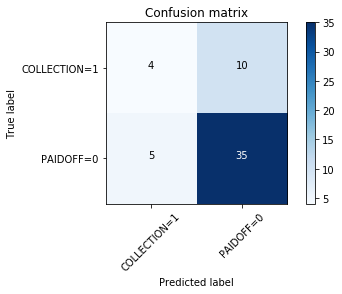

In [38]:
yhat = neigh.predict(X_test)

print("Jaccard: ", jaccard_similarity_score(y_test, yhat))
print("F1-score: ", f1_score(y_test, yhat, average='weighted'))

from sklearn.metrics import classification_report, confusion_matrix
import itertools
print("Classification_Report: \n", classification_report(y_test, yhat))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION=1','PAIDOFF=0'],normalize= False,  title='Confusion matrix')
KNN = {'Jaccard':jaccard_similarity_score(y_test, yhat), 'F1-score':f1_score(y_test, yhat, average='weighted'), 'LogLoss':'NA', 'F1-score Collection':f1_score(y_test, yhat, average='weighted', labels=[1])}

# Decision Tree -- Test

Jaccard:  0.6851851851851852
F1-score:  0.7037699595839131
Classification_Report: 
               precision    recall  f1-score   support

           0       0.96      0.60      0.74        40
           1       0.45      0.93      0.60        14

   micro avg       0.69      0.69      0.69        54
   macro avg       0.70      0.76      0.67        54
weighted avg       0.83      0.69      0.70        54



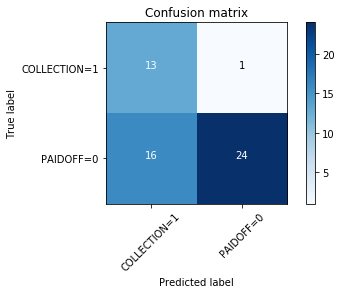

In [39]:
yhat = decTree.predict(X_test)

print("Jaccard: ", jaccard_similarity_score(y_test, yhat))
print("F1-score: ", f1_score(y_test, yhat, average='weighted'))
print("Classification_Report: \n", classification_report(y_test, yhat))

cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION=1','PAIDOFF=0'],normalize= False,  title='Confusion matrix')
DT = {'Jaccard':jaccard_similarity_score(y_test, yhat), 'F1-score':f1_score(y_test, yhat, average='weighted'), 'LogLoss':'NA', 'F1-score Collection':f1_score(y_test, yhat, average='weighted', labels=[1])}

# Support Vector Machine -- Test

Jaccard:  0.6666666666666666
F1-score:  0.6856060606060607
Classification_Report: 
               precision    recall  f1-score   support

           0       0.96      0.57      0.72        40
           1       0.43      0.93      0.59        14

   micro avg       0.67      0.67      0.67        54
   macro avg       0.70      0.75      0.65        54
weighted avg       0.82      0.67      0.69        54



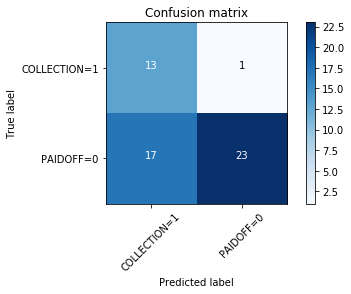

In [40]:
yhat = clf.predict(X_test)

print("Jaccard: ", jaccard_similarity_score(y_test, yhat))
print("F1-score: ", f1_score(y_test, yhat, average='weighted'))
print("Classification_Report: \n", classification_report(y_test, yhat))

cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION=1','PAIDOFF=0'],normalize= False,  title='Confusion matrix')
SVM = {'Jaccard':jaccard_similarity_score(y_test, yhat), 'F1-score':f1_score(y_test, yhat, average='weighted'), 'LogLoss':'NA', 'F1-score Collection':f1_score(y_test, yhat, average='weighted', labels=[1])}

# Logistic Regression -- Test

Jaccard:  0.6481481481481481
F1-score:  0.6689193665937851
LogLoss:  0.6011516923159436
Classification_Report: 
               precision    recall  f1-score   support

           0       0.92      0.57      0.71        40
           1       0.41      0.86      0.56        14

   micro avg       0.65      0.65      0.65        54
   macro avg       0.67      0.72      0.63        54
weighted avg       0.79      0.65      0.67        54



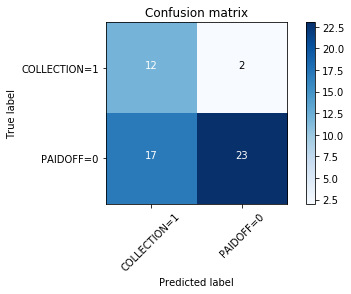

In [41]:
yhat = LR.predict(X_test)
yhat_prob = LR.predict_proba(X_test)

print("Jaccard: ", jaccard_similarity_score(y_test, yhat))
print("F1-score: ", f1_score(y_test, yhat, average='weighted'))
print("LogLoss: ", log_loss(y_test, yhat_prob))
print("Classification_Report: \n", classification_report(y_test, yhat))

cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION=1','PAIDOFF=0'],normalize= False,  title='Confusion matrix')
Lr = {'Jaccard':jaccard_similarity_score(y_test, yhat), 'F1-score':f1_score(y_test, yhat, average='weighted'), 'LogLoss':log_loss(y_test, yhat_prob), 'F1-score Collection':f1_score(y_test, yhat, average='weighted', labels=[1])}

# Final Table -- Test

In [42]:
table = [KNN, DT, SVM, Lr]
tableDF = pd.DataFrame(table)
tableDF['Algorithm'] = ['KNN', 'Decision Tree', 'SVM', 'LogisticRegression']
tableDF = tableDF[['Algorithm', 'Jaccard', 'F1-score', 'LogLoss', 'F1-score Collection']]
tableDF.set_index('Algorithm', inplace=True) 
tableDF

,Jaccard,F1-score,LogLoss,F1-score Collection
Algorithm,,,,
KNN,0.722222,0.700199,NA,0.347826
Decision Tree,0.685185,0.703770,NA,0.604651
SVM,0.666667,0.685606,NA,0.590909
LogisticRegression,0.648148,0.668919,0.601152,0.558140


<h3>Summary</h3>
<h6>According to the kind of problem, the main purpose of a bank is to predict those customer who really make default, 
so the best criteria to take into account is the f-1 score on collection group. Going deeper, the parameter "recall" for "collection" 
is even more important for banks since a better value is lower the occurence of false negatives. According to both parameters, 
Decision Tree and Logistic Regression showed good results, f-1 score "collection" = 0.6 and recall "collection" = 0.93. 
In conclusion, both methods can be selected under these considerations.</h6>

# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                |  0.722  |  0.700   |   NA    |
| Decision Tree      |  0.685  |  0.703   |   NA    |
| SVM                |  0.666  |  0.685   |   NA    |
| LogisticRegression |  0.648  |  0.668   |  0.558  |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>